In [2]:
import pandas as pd
import os
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# import ants
import sys
import json
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.gridspec as gridspec


%load_ext autoreload
%autoreload 2

In [2]:
# uname = os.environ.get('USER')

# if uname == 'emil':
#     projdir = '/Users/emil/Projects/QA/CaliberPaper/lunarc/QA_paper/project'
# elif uname == 'em2876lj':
#     projdir = '/home/em2876lj/Projects/QA/QA_paper/project'

# notebook_path = f'{projdir}/code/unity_qa_paper/notebooks/'
# if notebook_path not in sys.path:
#     sys.path.append(notebook_path)

# from contrast_help import add_temperature_w0
# from stats_help import show_bootstrap, check_model, bootstrap_formula
# from distortions_help import get_distortions_df

In [4]:
df = pd.read_csv('../data/distortions_df.csv')

df['MagDiff'] = np.sqrt(df['x_diff']**2 + df['y_diff']**2 + df['z_diff']**2)
df['LabelValue'] = df['LabelValue'].astype(int)

## Reproducibility on axial scans

In [5]:
df_pivot = df[(df.Method == 'UNet') & (df.Axis == 'axi')].pivot(index=['Subject','LabelValue', 'Session'], columns='Run')
diff_x = df_pivot[('x_org', 1)] - df_pivot[('x_org', 2)]
diff_y = df_pivot[('y_org', 1)] - df_pivot[('y_org', 2)]
diff_z = df_pivot[('z_org', 1)] - df_pivot[('z_org', 2)]
diff_mag_3D = np.sqrt(diff_x**2 + diff_y**2 + diff_z**2)
diff_mag_2D = np.sqrt(diff_x**2 + diff_y**2)

diff_df = pd.DataFrame({'X':diff_x, 'Y':diff_y, 'Z':diff_z, 'Mag3D':diff_mag_3D, 'Mag2D':diff_mag_2D})

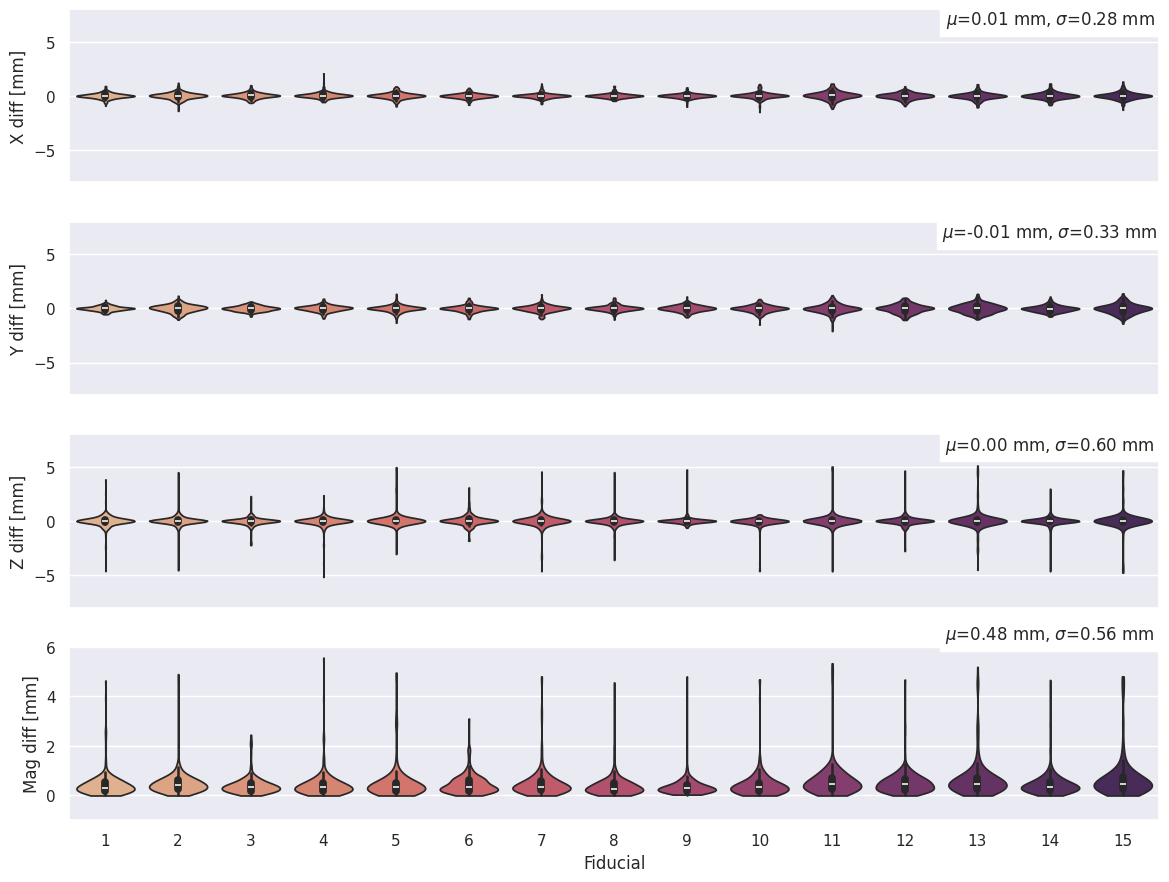

In [6]:
sns.set_theme()
fig, axes = plt.subplots(4,1,figsize=(12,9))

text_y = [7,7,7,6.5]
for i,k in enumerate(['X', 'Y', 'Z', 'Mag3D']):
    sns.violinplot(diff_df, x='LabelValue', y=k, hue='LabelValue', legend=None, ax=axes[i], cut=0, palette='flare')
    axes[i].text(13,text_y[i],fr"$\mu$={diff_df[k].mean():.2f} mm, $\sigma$={diff_df[k].std():.2f} mm", 
                 horizontalalignment='center', verticalalignment='center', backgroundcolor='w')

for i in range(3):
    axes[i].set_xlabel(None)
    axes[i].set_xticks([])

for ax in axes:
    ax.set_ylim([-8,8])

axes[3].set_ylim([-1,6])

axes[0].set_ylabel('X diff [mm]')
axes[1].set_ylabel('Y diff [mm]')
axes[2].set_ylabel('Z diff [mm]')
axes[3].set_ylabel('Mag diff [mm]')
axes[3].set_xlabel('Fiducial')

plt.tight_layout()
plt.show()


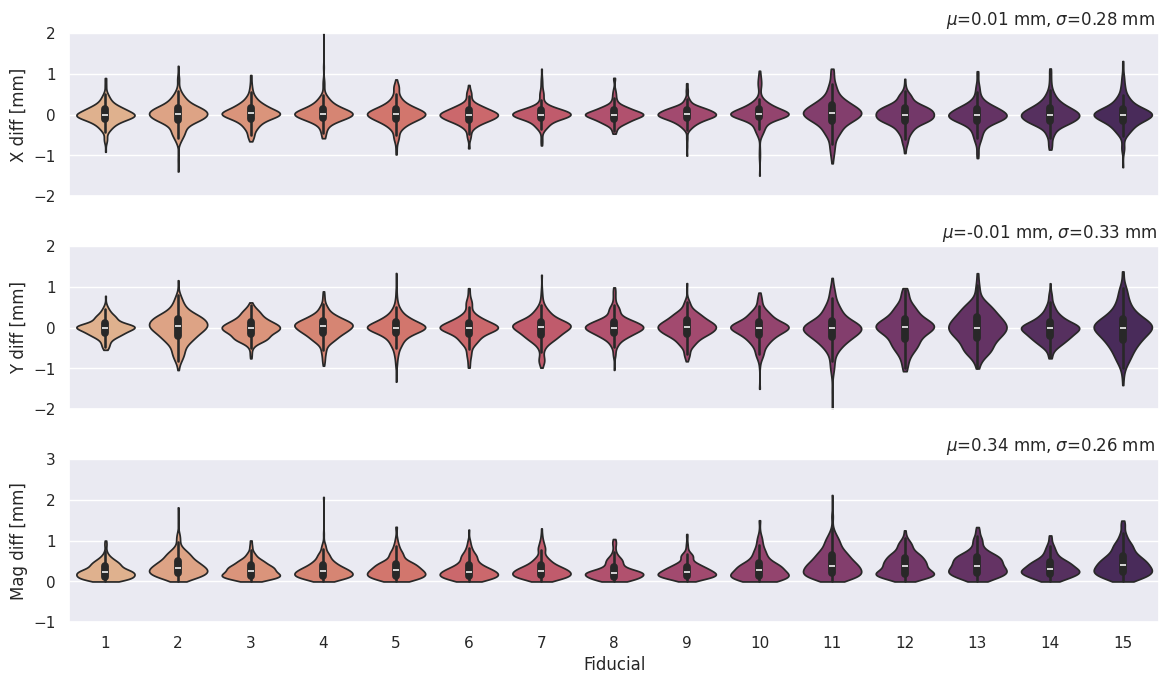

In [7]:
sns.set_theme()
fig, axes = plt.subplots(3,1,figsize=(12,7))

for i,k in enumerate(['X', 'Y', 'Mag2D']):
    sns.violinplot(diff_df, x='LabelValue', y=k, hue='LabelValue', legend=None, ax=axes[i], cut=0, palette='flare')
    if i==2:
        y = 3.2
    else:
        y = 2.2
    axes[i].text(13,y,fr"$\mu$={diff_df[k].mean():.2f} mm, $\sigma$={diff_df[k].std():.2f} mm", horizontalalignment='center')

for i in range(2):
    axes[i].set_xlabel(None)
    axes[i].set_xticks([])

for ax in axes:
    ax.set_ylim([-2,2])

axes[2].set_ylim([-1,3])
axes[0].set_ylabel('X diff [mm]')
axes[1].set_ylabel('Y diff [mm]')
axes[2].set_ylabel('Z diff [mm]')
axes[2].set_ylabel('Mag diff [mm]')
axes[2].set_xlabel('Fiducial')

plt.tight_layout()
plt.show()


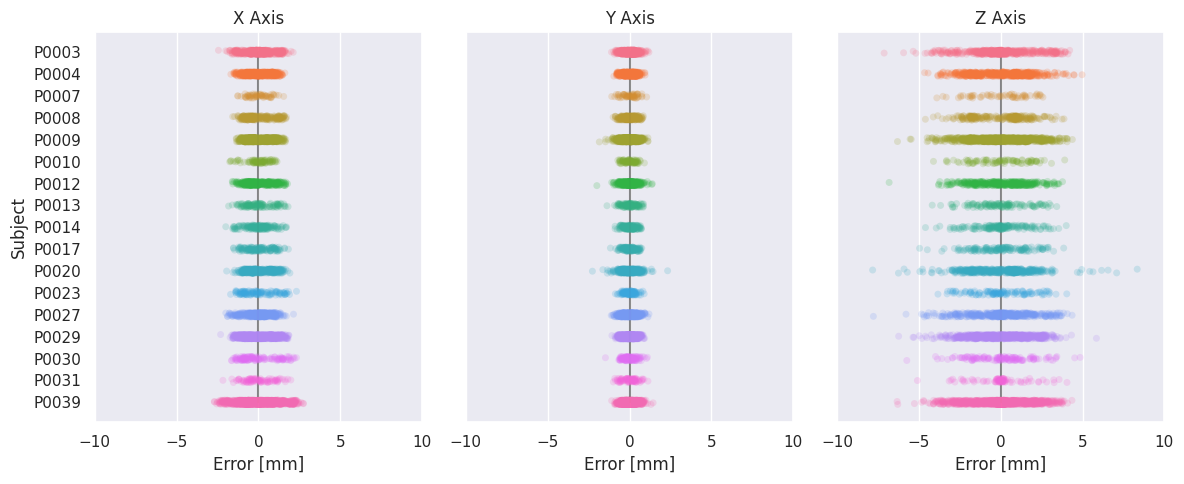

In [8]:
fig, axes = plt.subplots(1,3, figsize=(12,5))
scan_ax = 'axi'
sns.stripplot(data=df[(df['Axis']==scan_ax) & (df['Run']==1)], x='x_diff', y='Subject', ax=axes[0], hue='Subject', alpha=0.2, orient='h')
sns.stripplot(data=df[(df['Axis']==scan_ax) & (df['Run']==1)], x='y_diff', y='Subject', ax=axes[1], hue='Subject', alpha=0.2, orient='h')
sns.stripplot(data=df[(df['Axis']==scan_ax) & (df['Run']==1)], x='z_diff', y='Subject', ax=axes[2], hue='Subject', alpha=0.2, orient='h')

axes[1].set_ylabel(None)
axes[1].set_yticks([])

axes[2].set_ylabel(None)
axes[2].set_yticks([])

for ax in axes:
    ax.set_xlim([-10,10])

    ax.plot([0,0],[0,16], '-k', alpha=0.5)
    ax.set_xlabel('Error [mm]')

axes[0].set_title('X Axis')
axes[1].set_title('Y Axis')
axes[2].set_title('Z Axis')

plt.tight_layout()
plt.show()

In [9]:
def add_jitter(ax, data, x_col, y_col, hue_col, dodge_amount=0.05):
    # Get unique values of x and hue
    x_unique = data[x_col].unique()
    hue_unique = data[hue_col].unique()

    for i, x_val in enumerate(x_unique):
        for j, hue_val in enumerate(hue_unique):
            # Get the subset of the data for the specific x and hue
            subset = data[(data[x_col] == x_val) & (data[hue_col] == hue_val)]
            # Calculate the dodge value
            dodge_value = (j - len(hue_unique) / 2) * dodge_amount
            # Apply jitter and dodge
            jittered_x = i + dodge_value + np.random.uniform(-dodge_amount, dodge_amount, size=len(subset))
            # Plot the jittered points
            ax.scatter(jittered_x, subset[y_col], label=f'{x_val}, {hue_val}')

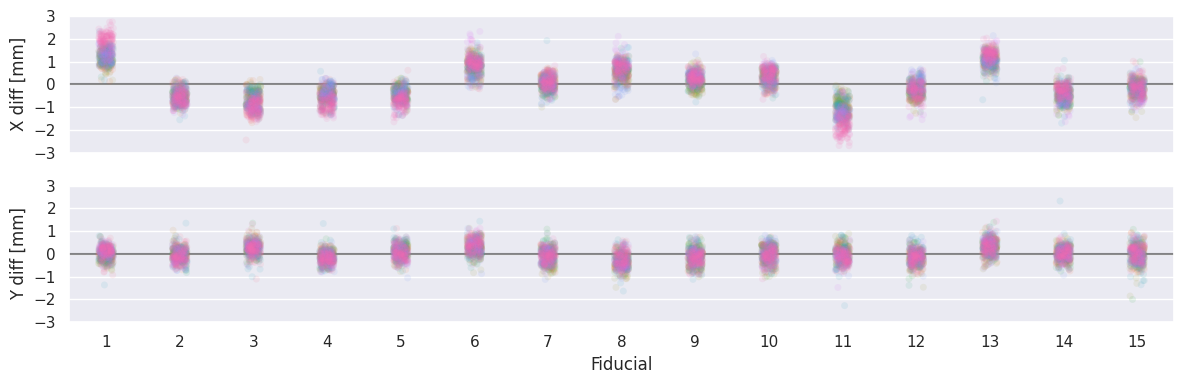

In [10]:
fig, axes = plt.subplots(2,1,figsize=(12,4))

scan_ax='axi'
sns.stripplot(data=df[(df['Axis']==scan_ax) & (df['Run']==1)], y='x_diff', 
              x='LabelValue', ax=axes[0], hue='Subject', alpha=0.1, legend=None)

sns.stripplot(data=df[(df['Axis']==scan_ax) & (df['Run']==1)], y='y_diff', 
              x='LabelValue', ax=axes[1], hue='Subject', alpha=0.1, legend=None)

axes[0].plot(axes[0].get_xlim(),[0,0], '-k', alpha=0.5)
axes[1].plot(axes[1].get_xlim(),[0,0], '-k', alpha=0.5)

axes[0].set_xlabel(None)
axes[0].set_xticks([])

axes[0].axis([-0.5,14.5,-3,3])
axes[1].axis([-0.5,14.5,-3,3])

axes[0].set_ylabel('X diff [mm]')
axes[1].set_ylabel('Y diff [mm]')
axes[1].set_xlabel('Fiducial')

axes[0].set_yticks([-3,-2,-1,0,1,2,3])
axes[1].set_yticks([-3,-2,-1,0,1,2,3])

plt.tight_layout()
plt.show()


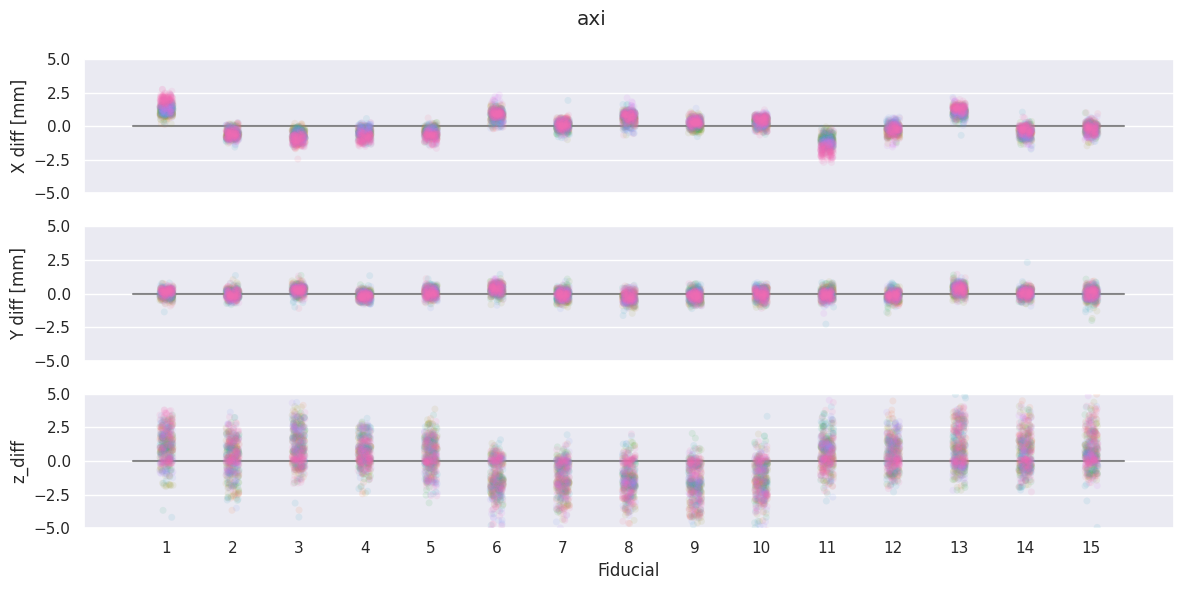

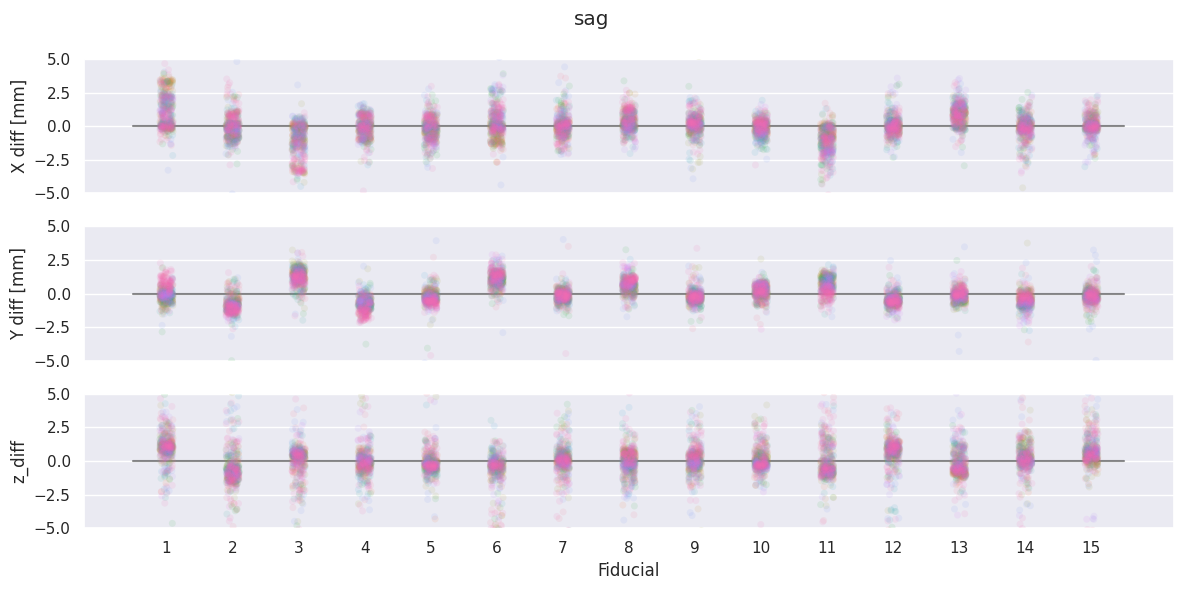

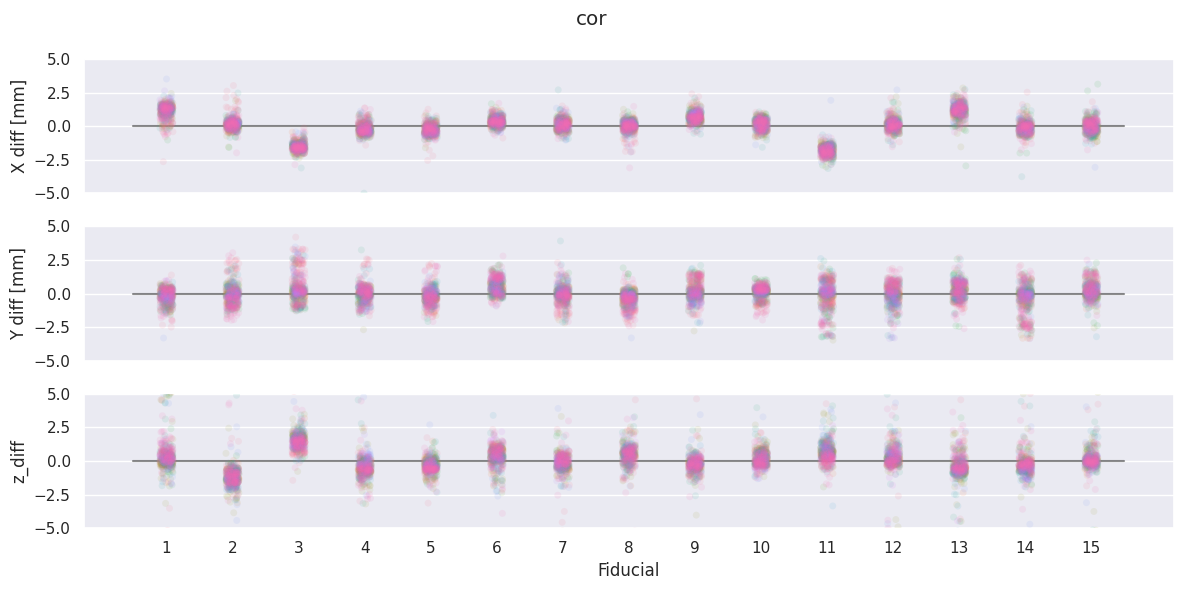

In [11]:
for scan_ax in ['axi', 'sag', 'cor']:
    fig, axes = plt.subplots(3,1,figsize=(12,6))


    sns.stripplot(data=df[(df['Axis']==scan_ax) & (df['Run']==1)], y='x_diff', 
                x='LabelValue', ax=axes[0], hue='Subject', alpha=0.1, legend=None)

    sns.stripplot(data=df[(df['Axis']==scan_ax) & (df['Run']==1)], y='y_diff', 
                x='LabelValue', ax=axes[1], hue='Subject', alpha=0.1, legend=None)

    sns.stripplot(data=df[(df['Axis']==scan_ax) & (df['Run']==1)], y='z_diff', 
                x='LabelValue', ax=axes[2], hue='Subject', alpha=0.1, legend=None)

    axes[0].plot(axes[0].get_xlim(),[0,0], '-k', alpha=0.5)
    axes[1].plot(axes[1].get_xlim(),[0,0], '-k', alpha=0.5)
    axes[2].plot(axes[2].get_xlim(),[0,0], '-k', alpha=0.5)

    axes[0].set_xlabel(None)
    axes[0].set_xticks([])
    axes[1].set_xlabel(None)
    axes[1].set_xticks([])

    for i in range(3):
        axes[i].set_ylim([-5,5])

    axes[0].set_ylabel('X diff [mm]')
    axes[1].set_ylabel('Y diff [mm]')
    axes[2].set_xlabel('Fiducial')

    plt.suptitle(scan_ax)
    plt.tight_layout()
    plt.show()


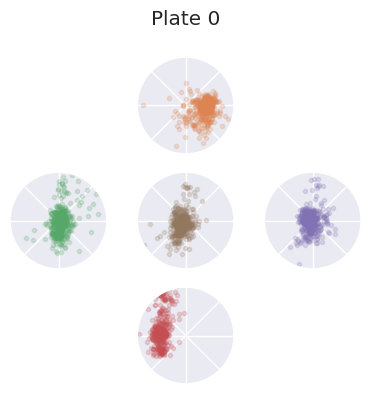

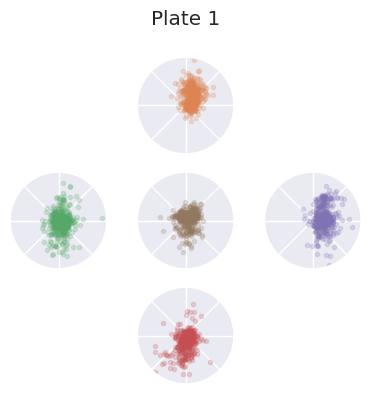

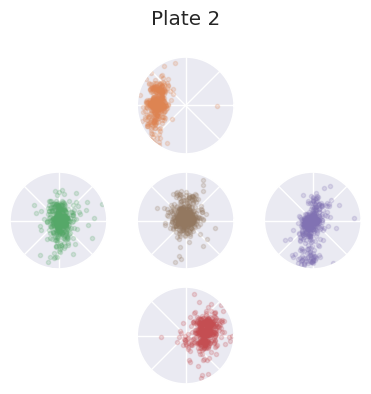

In [12]:
for plate in [0,1,2]:
    fig, axes = plt.subplots(ncols=3, nrows=3, subplot_kw={'projection':'polar'}, figsize=(4,4))

    for i,k in zip([1,2,3,4,5],[(0,1),(1,0),(2,1),(1,2),(1,1)]): 
        data = df[(df['Axis']==scan_ax) & (df['Run']==1) & (df['LabelValue']==i+plate*5)]
        x = data.x_diff
        y = data.y_diff
        theta = np.atan2(y,x)
        r = np.sqrt(x**2+y**2)
        axes[k].plot(theta, r, '.', alpha=0.2, color=f'C{i:02d}')

    axes[0,0].axis('off')
    axes[2,2].axis('off')
    axes[0,2].axis('off')
    axes[2,0].axis('off')

    for ax in axes.flatten():
        ax.set_xticklabels([])
        ax.set_rticks([])
        ax.axis([None,None,None,3])
    
    plt.suptitle(f'Plate {plate}')
    plt.tight_layout()
    plt.show()

In [15]:
df_scale = pd.read_csv('../data/distortions_scale_df.csv')

In [13]:
# Modify df_scale with SW, temp and w0
df_temp = pd.read_csv('/home/em2876lj/Projects/QA/QA_paper/project/derivatives/fisp_temperature_w0.csv')
df_temp['Temperature'] = 24-df_temp['n_black']

df_scale['Temperature'] = 0
df_scale['w0'] = 0
df_scale['SoftwareVersions'] = ''

for sub in df_scale.Subject.unique():
    sub_df = df_scale[df_scale.Subject==sub]

    for ses in sub_df.Session.unique():

        # Software level
        f = layout.get(scope='raw', subject=sub, 
                                    session=ses, extension='.json', 
                                    reconstruction='axi')[0]

        with open(f,'r') as jf:
            my_sw = json.load(jf)["SoftwareVersions"]
        
        my_temp = df_temp[(df_temp['Subject']==sub) & (df_temp['Session']==ses)].Temperature.values[0]
        my_w0 = df_temp[(df_temp['Subject']==sub) & (df_temp['Session']==ses)].w0.values[0]

        my_filt = (df_scale.Subject==sub) & (df_scale.Session==ses) 
        
        df_scale.loc[my_filt,'Temperature'] = my_temp
        df_scale.loc[my_filt,'w0'] = my_w0
        df_scale.loc[my_filt,'SoftwareVersions'] = my_sw

df_scale.Temperature = df_scale.Temperature.astype('float64')
df_scale.w0 = df_scale.w0.astype('float64')

/local/slurmtmp.843159/ipykernel_435328/3657036448.py:28: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.730387' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



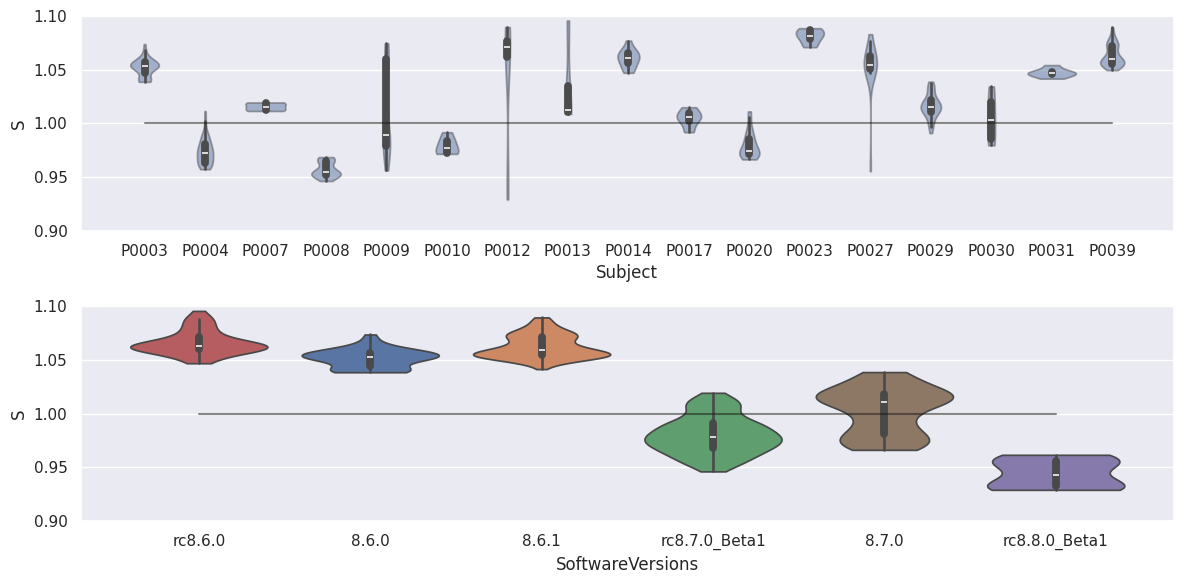

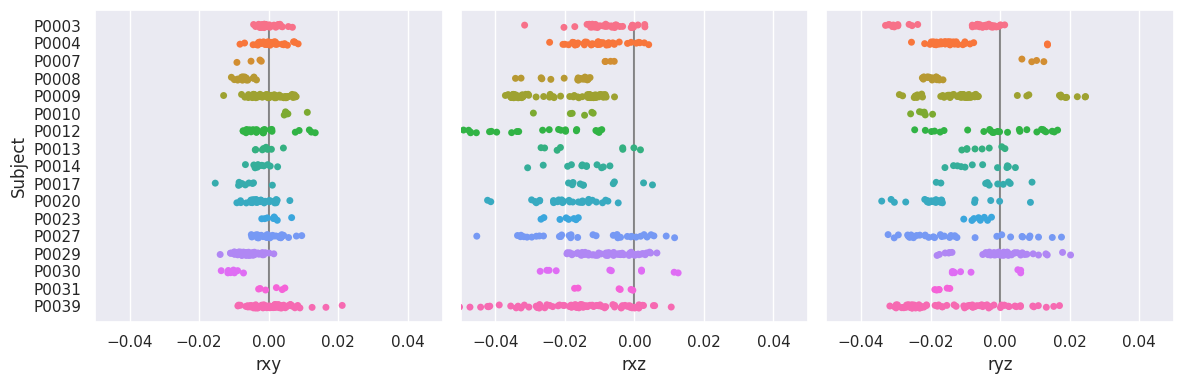

In [14]:
fig, axes = plt.subplots(2,1, figsize=(12,6))

sns.violinplot(df_scale[df_scale.Axis=='axi'], x='Subject', y='S', ax=axes[0], alpha=0.5, legend=None, cut=0)
axes[0].plot([0,16], [1.0,1.0], '-k', alpha=0.5)
axes[0].axis([None, None, 0.9, 1.1, ])

sns.violinplot(df_scale[df_scale.Axis=='axi'], x='SoftwareVersions', y='S', hue='SoftwareVersions', alpha=1, ax=axes[1], cut=0,
               order=['rc8.6.0', '8.6.0', '8.6.1', 'rc8.7.0_Beta1','8.7.0','rc8.8.0_Beta1'])
axes[1].plot([0,5], [1.0,1.0], '-k', alpha=0.5)
axes[1].axis([None, None, 0.9, 1.1, ])

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1,3, figsize=(12,4))
sns.stripplot(df_scale[df_scale.Axis=='axi'], y='Subject', x='rxy', hue='Subject', orient='h', ax=axes[0])
sns.stripplot(df_scale[df_scale.Axis=='axi'], y='Subject', x='rxz', hue='Subject', orient='h', ax=axes[1])
sns.stripplot(df_scale[df_scale.Axis=='axi'], y='Subject', x='ryz', hue='Subject', orient='h', ax=axes[2])

axes[1].set_ylabel(None)
axes[2].set_ylabel(None)
axes[1].set_yticks([])
axes[2].set_yticks([])

for ax in axes:
    ax.plot([0,0],[0,16], '-k', alpha=0.5)
    ax.axis([-0.05, 0.05, None, None])

plt.tight_layout()
plt.show()

/local/slurmtmp.843159/ipykernel_435328/1108041548.py:9: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/local/slurmtmp.843159/ipykernel_435328/1108041548.py:10: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



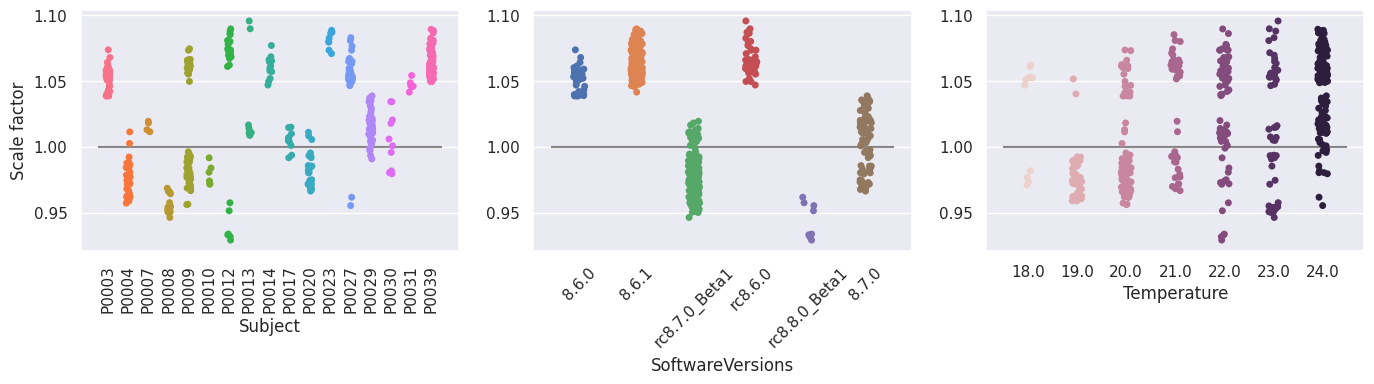

In [15]:
fig, axes = plt.subplots(1,3, figsize=(14,4))
sns.stripplot(df_scale[df_scale.Axis=='axi'], y='S', x='Subject', hue='Subject', ax=axes[0], legend=None)
sns.stripplot(df_scale[df_scale.Axis=='axi'], y='S', x='SoftwareVersions', hue='SoftwareVersions', ax=axes[1], legend=False)
sns.stripplot(df_scale[df_scale.Axis=='axi'], y='S', x='Temperature', hue='Temperature', ax=axes[2], legend=None)

axes[1].set_ylabel(None)
axes[2].set_ylabel(None)

axes[0].set_xticklabels(labels=axes[0].get_xticklabels(), rotation=90)
axes[1].set_xticklabels(labels=axes[1].get_xticklabels(), rotation=45)

for ax in axes:
    ax.hlines(1, ax.get_xlim()[0], ax.get_xlim()[1], color='k', linestyles='-', alpha=0.5)
    # ax.axis([-0.05, 0.05, None, None]) 


axes[0].set_ylabel('Scale factor')
plt.tight_layout()
plt.show()

In [16]:
model = smf.ols("S ~ Temperature + C(SoftwareVersions) + C(Subject)", data=df_scale)
res = model.fit()
anova_results = sm.stats.anova_lm(res, typ=2)
anova_results


,sum_sq,df,F,PR(>F)
C(SoftwareVersions),0.221573,5.0,68.190615,6.341981e-61
C(Subject),0.101513,16.0,9.762970,5.665988e-23
Temperature,0.000493,1.0,0.758518,3.840136e-01
Residual,0.614770,946.0,NaN,NaN


## Distortions intensity

In [17]:
dp = '/home/em2876lj/Projects/QA/QA_paper/project/code/nnUnet_inference/tempdir_nnUNet_inference_fb6i9pqw'

In [18]:
imax = 968
imax = 100
all_rows = []
for idx in range(1,imax+1):
    img = ants.image_read(f"{dp}/input/UNITY_{idx:04d}_0000.nii.gz")
    seg = ants.image_read(f"{dp}/final/UNITY_{idx:04d}.nii.gz")
    seg_data = ants.label_stats(img, seg)    
    seg_data['idx'] = idx
    all_rows.append(seg_data)

In [19]:
my_df = pd.concat(all_rows)
my_df = my_df[my_df.LabelValue > 0]

<Axes: xlabel='LabelValue', ylabel='Mean'>

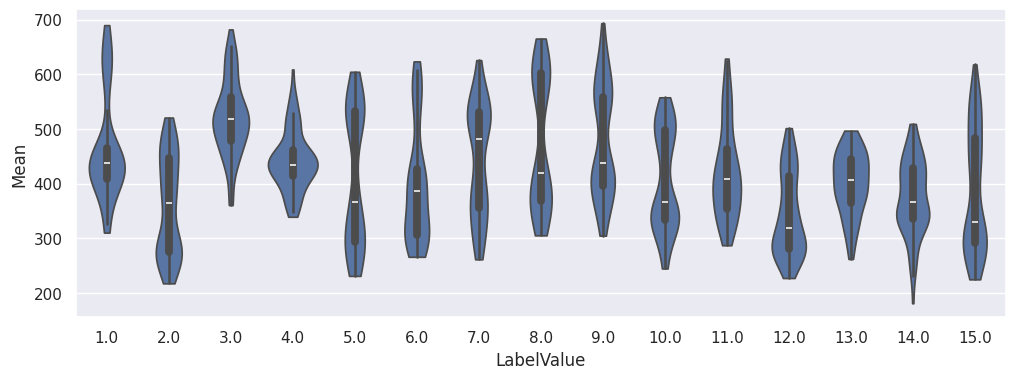

In [20]:
sns.set_theme()
fig = plt.figure(figsize=(12,4))
sns.violinplot(my_df, x='LabelValue', y='Mean', cut=0)